In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import xgboost as xgb
import json

from scipy.stats import norm
from data_generation import m_0, g_0, get_data
from dml_algorithm import dml_ate

## Load tuned hyperparameters of XGBoost for each sample size

In [2]:
with open('opt_params_xgboost.json', 'r') as json_file:
    opt_params_dict_dict = json.load(json_file)

## Infeasible method-of-moments estimator

In [3]:
def mm_ate(y_data, d_data, x_data):
    return np.mean(g_0(1, x_data) - g_0(0, x_data) + d_data*(y_data-g_0(1, x_data))/m_0(x_data)
                   - (1-d_data)*(y_data-g_0(0, x_data))/(1-m_0(x_data)))

## MC simulation

In [7]:
%%time
np.random.seed(100)
n_MC = 250
K = 5
results_dict = {}

for N, opt_params_dict in opt_params_dict_dict.items():
    ate_estimates = np.empty((n_MC, 4))
    sigma_estimates = np.empty(n_MC)
    CIs = np.empty((n_MC, 2)) 
    for j in range(n_MC):        
        y_data, d_data, x_data = get_data(int(N))
        ate_estimates[j, 0] = mm_ate(y_data, d_data, x_data)
        model_g0, model_g1 = xgb.XGBRegressor(tree_method='hist'), xgb.XGBRegressor(tree_method='hist')
        model_g0.set_params(**opt_params_dict['g0'])
        model_g1.set_params(**opt_params_dict['g1'])
        model_g = [model_g0, model_g1]
        model_m = xgb.XGBClassifier(tree_method='hist')
        model_m.set_params(**opt_params_dict['m'])
        ate_estimates[j, 1:], sigma_estimates[j], CI[j] = dml_ate(K, y_data, d_data, x_data, model_g, model_m)
    results_dict[int(N)] = [ate_estimates, sigma_estimates, CIs]

CPU times: total: 53min 3s
Wall time: 16min 12s


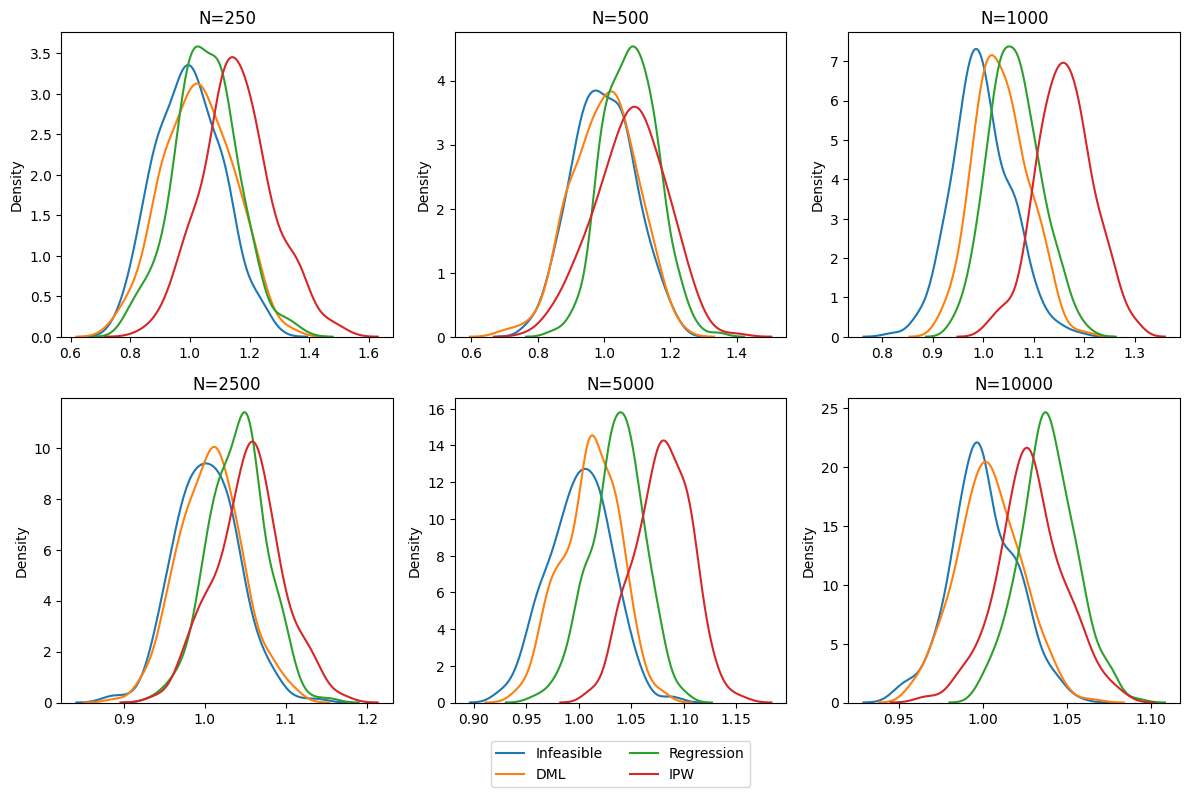

In [55]:
# Visual comparison
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for k, (N, results) in enumerate(results_dict.items()):
    i, j = k//3, k%3 
    ate_estimates, _, _ = results
    sns.kdeplot(ate_estimates[:,0], ax=axes[i,j], label='Infeasible')
    sns.kdeplot(ate_estimates[:,1], ax=axes[i,j], label='DML')
    sns.kdeplot(ate_estimates[:,2], ax=axes[i,j], label='Regression')
    sns.kdeplot(ate_estimates[:,3], ax=axes[i,j], label='IPW')
    axes[i,j].set_title(f'N={N}')
    if i == 1 and j == 1:
        axes[i,j].legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)
  
plt.tight_layout()    
plt.show()

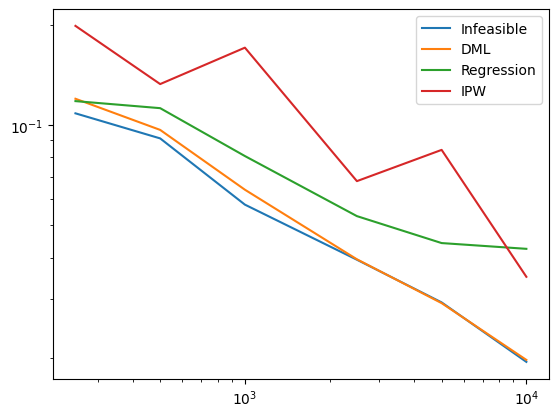

In [38]:
# Convergence rates
theta_0 = 1.0   # true ATE
sample_sizes = np.array([N for N in results_dict.keys()])
rmse = np.empty((len(sample_sizes), 4))

for k, (N, results) in enumerate(results_dict.items()):
    ate_estimates, _, _ = results
    rmse[k] = np.sqrt(np.mean((ate_estimates-theta_0)**2, axis=0))

plt.plot(sample_sizes, rmse[:,0], label='Infeasible')
plt.plot(sample_sizes, rmse[:,1], label='DML')
plt.plot(sample_sizes, rmse[:,2], label='Regression')
plt.plot(sample_sizes, rmse[:,3], label='IPW')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

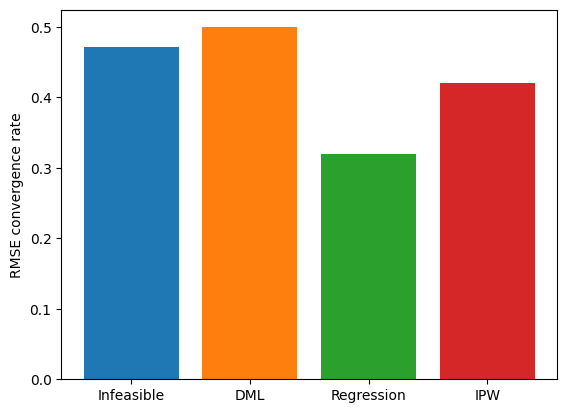

In [50]:
# Convergence rates
slopes = []
for k in range(4):
    slope = np.polyfit(np.log(sample_sizes), np.log(rmse[:,k]), 1)[0]
    slopes.append(-slope)

plt.bar(['Infeasible', 'DML', 'Regression', 'IPW'], slopes, color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red'])
plt.ylabel('RMSE convergence rate')
plt.show()

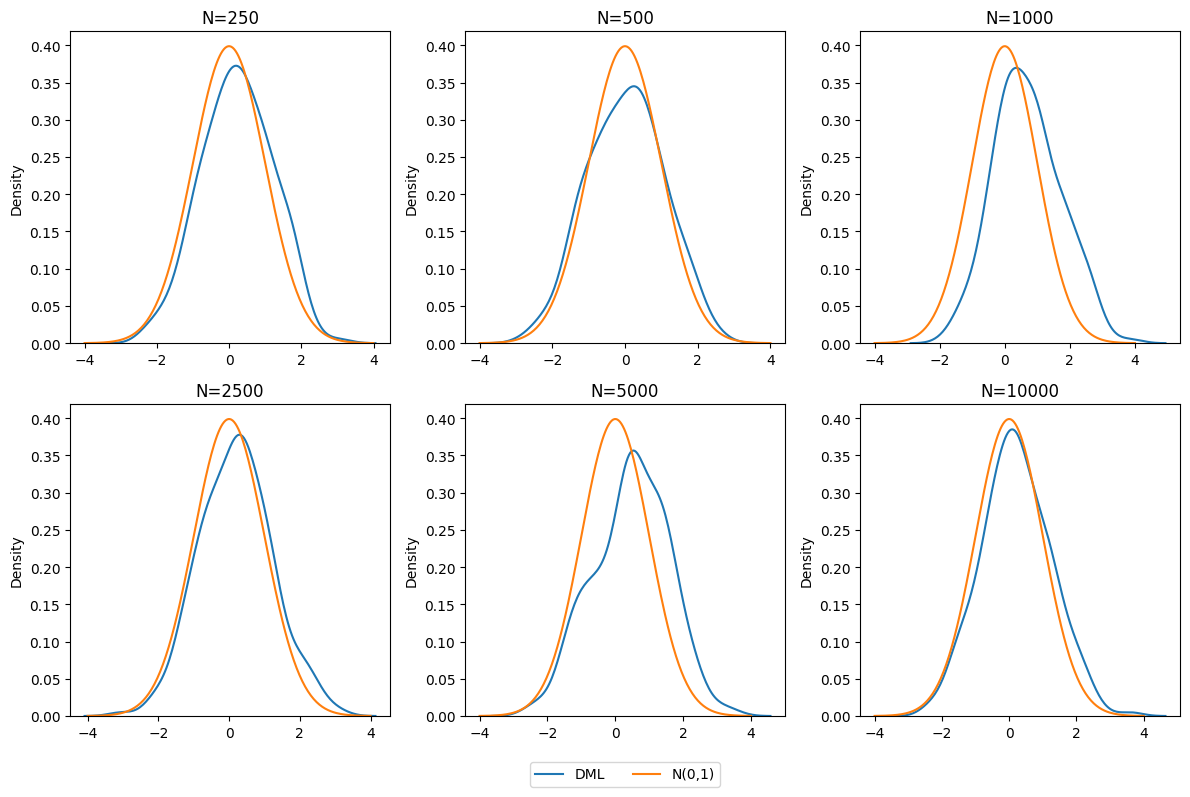

In [63]:
# Visual comparison
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for k, (N, results) in enumerate(results_dict.items()):
    i, j = k//3, k%3
    ate_estimates, sigma_estimates, _ = results
    sns.kdeplot(np.sqrt(N)*(ate_estimates[:,1]-theta_0)/sigma_estimates, ax=axes[i,j], label='DML')
    grid = np.linspace(-4, 4, 200)
    pdf_values = norm.pdf(grid)
    axes[i,j].plot(grid, pdf_values, label='N(0,1)')
    axes[i,j].set_title(f'N={N}')
    if i == 1 and j == 1:
        axes[i, j].legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
  
plt.tight_layout()    
plt.show()

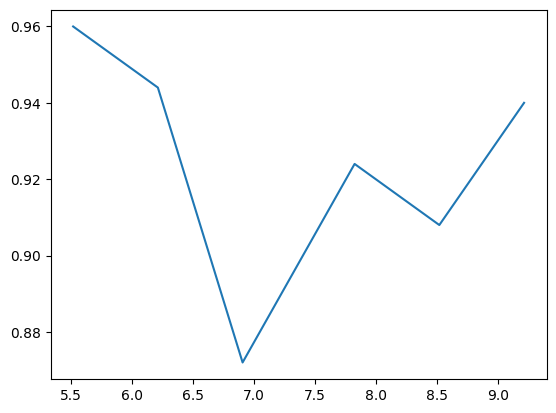

In [68]:
# Coverage probability
cov_prob_list = []

for _, results in results_dict.items():
    _, _, CIs = results
    cov_prob = np.mean((theta_0>=CIs[:,0]) & (theta_0<=CIs[:,1]))
    cov_prob_list.append(cov_prob)

plt.plot(np.log(sample_sizes), cov_prob_list)
plt.show()